In [ ]:
!pip install gymnasium

In [1]:
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Video
import torch
import numpy as np
from agent import QLearningAgent,DQNAgent,REINFORCE,ActorCritic,A2C
import cv2
from torch.utils.tensorboard import SummaryWriter  # Import TensorBoard
import wandb
use_wandb = False

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
env = gym.make("LunarLander-v3", render_mode="rgb_array")
observation, info = env.reset(seed=42)

def show_env(env):
    frame = env.render()
    plt.imshow(frame)
    plt.axis('off')
    plt.show()

def plot(x,ylabel='Loss'):
    # === Plot ===
    plt.xlabel('Episode')
    plt.ylabel(ylabel)
    plt.plot(range(len(x)), x)
    plt.show()

def test_agent(agent, env="LunarLander-v3", num_envs=8, num_episodes=1000):
    """
    并行测试智能体在多个环境中的表现，不进行学习和探索。
    输入:
        agent: 智能体对象，需实现 get_action 方法
        num_envs: 并行环境数量
        num_episodes: 总测试回合数
    输出:
        绘制奖励分布图
        """
        # 这里必须是工厂函数列表
    envs =  gym.make_vec(env, num_envs=num_envs, vectorization_mode="sync") # 同步环境
    total_rewards = []
    episodes_per_env = num_episodes // num_envs
    agent.eval()

    for _ in range(episodes_per_env):
        states, infos = envs.reset()
        dones = [False] * num_envs
        rewards = [0.0] * num_envs

        while not all(dones):
            actions, _, _ = agent.get_action(states)
            next_states, step_rewards, terminated, truncated, infos = envs.step(actions)
            for i in range(num_envs):
                if not dones[i]:
                    rewards[i] += step_rewards[i]
                    dones[i] = terminated[i] or truncated[i]
            states = next_states
        total_rewards.extend(rewards)

    plt.figure(figsize=(8,5))
    plt.hist(total_rewards, bins=30, color='skyblue', edgecolor='black')
    plt.xlabel('reward')
    plt.ylabel('episodes')
    plt.title(f'{num_episodes} episodes-reward distribution')
    plt.show()
    
def save_video(agent, env, file_name):
    frames = []
    obs, infos = env.reset()
    sum_reward = 0
    agent.eval()
    while True:
        action, prob, _ = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        obs = next_obs
        sum_reward += reward

        frame = env.render()
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        cv2.putText(frame, f"Reward: {sum_reward:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                    1, (0, 255, 0), 2, cv2.LINE_AA)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)

        if terminated or truncated:
            break

    # 保存为视频
    imageio.mimsave(file_name, frames, fps=30)
    Video(file_name, embed=True)

In [ ]:
print('动作空间：', env.action_space)
print('观察空间: ', env.observation_space) # 8个值的区间
# 观察就是部分状态

In [ ]:
frames = []

while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    frame = env.render()
    frames.append(frame)
    if terminated or truncated:
        break

# 保存为视频
imageio.mimsave('lunarlander.mp4', frames, fps=30)
Video('lunarlander.mp4', embed=True)

In [ ]:
agent = QLearningAgent(
        state_size=8,
        action_size=2,
        device=device)
agent.qnet.to(device)  # 模型转到GPU

episodes = 1000
loss_history = []

for episode in range(episodes):
    state, info = env.reset()
    total_loss, cnt = 0, 0
    terminated = False
    truncated = False
    t = 0

    while not (terminated or truncated):
        action = agent.getAction(state)
        next_state, reward, terminated, truncated, info = env.step(action)

        loss = agent.update(state, action, reward, next_state, terminated or truncated)
        state = next_state
        t += 1
    agent.epsilon_update()

    writer.add_scalar('Loss/train', loss, episode)
    writer.add_scalar('Reward/train', reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)
    writer.add_scalar('Epl/train', t, episode)

In [ ]:
plt.xlabel('episode')
plt.ylabel('loss')
plt.plot(range(len(loss_history)), loss_history)
plt.show()

In [ ]:
# 保存权重
torch.save(agent.qnet.state_dict(), "lunar_lander.pth")

In [ ]:
agent = DQNAgent(
    lr=0.0001,
    epsilon=1,
    epsilon_decay=0.995,
    TAU=0.005,
    batch_size=128,
    buffer_size=10000,
    action_size=4,
    device=device,
    use_cnn=False
    )

In [ ]:

agent.train()
writer = SummaryWriter()
episodes = 600

for episode in range(episodes):
    state, info = env.reset()
    done = False
    t = 0
    total_reward = 0
    while not done:
        action, Q = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        loss = agent.update(state, action, reward, next_state, done)
        t += 1
        state = next_state
        total_reward += reward

    agent.epsilon_update()
    writer.add_scalar('Loss/train', loss, episode)
    writer.add_scalar('Reward/train', total_reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)
    writer.add_scalar('Epsilon/train', agent.epsilon, episode)

writer.close()

In [ ]:
agent.save("models/dqn_lunar_lander.pth")

In [ ]:
agent.load("models/dqn_lunar_lander.pth")

In [ ]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

In [ ]:
save_video(agent, env,'dqn_lunarlander.mp4')

In [ ]:
agent = REINFORCE(
    lr=0.001,
    action_size=4)
episodes=5000

In [ ]:
for episode in range(episodes):
    state, info = env.reset()
    terminated = False
    truncated = False
    sum_reward = 0

    while not (terminated or truncated): 
        action, prob = agent.get_action(state)
        next_state, reward, terminated, truncated, info = env.step(action.item())

        agent.add(reward, prob)
        state = next_state
        sum_reward += reward

    loss = agent.update()

    if episode % 100 == 0:
        print("episode :{}, total reward : {:.1f}, loss : {:.4f}".format(episode, sum_reward, loss))

In [ ]:
torch.save(agent.pi.state_dict(), "models/reinforce_lunar_lander2.pth")

In [ ]:
agent.pi.load_state_dict(torch.load("models/reinforce_lunar_lander2.pth"))

In [ ]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

In [ ]:
save_video(agent, env)

In [ ]:
hyperparams = {
    'lr_pi': 0.001,
    'lr_v': 0.0002,
    'gamma': 0.98
}
agent = ActorCritic(
    action_size=4,
    device='cpu',
    **hyperparams
)
# agent.train()
writer = SummaryWriter(comment="ActorCritic")
writer.add_hparams(hyperparams, {})
episodes = 600

for episode in range(episodes):
    state, info = env.reset()
    done = False
    t = 0
    actor_loss = 0
    critic_loss = 0
    total_reward = 0

    while not done: 
        action, action_probs = agent.get_action(state)
        next_state, reward,  terminated, truncated, info = env.step(action)
        
        done = (terminated or truncated)
        losses = agent.update(state, action, action_probs, reward, next_state, done)
        state = next_state
        actor_loss += losses['actor_loss']
        critic_loss += losses['critic_loss']
        total_reward += reward
        t += 1

    writer.add_scalar('Actor Loss/train', actor_loss, episode)
    writer.add_scalar('Critic Loss/train', critic_loss, episode)
    writer.add_scalar('Reward/train', total_reward, episode)
    writer.add_scalar('Episode Duration/train', t, episode)

writer.close()

In [ ]:
config = {
    'agent': 'A2C',
    'action_size': 4,
    'device': device,
    'lr': 7e-4,
    'gamma': 0.99,
    'max_grad_norm': 0.5,
    'policy_coef': 1,
    'value_coef': 0.5,
    'entropy_coef': 0.5, # 鼓励模型探索，避免过早收敛到某个确定动作
    'total_steps': 50_000,
    'num_env': 128
}
agent = A2C(
    **config
)

In [4]:
if use_wandb:
    wandb.init(
        project="LunarLander-v3",
        config=config,  # 直接传入你的 config 字典
        name="A2C训练"
    )
else:
    writer = SummaryWriter(comment="A2C")
env_vec = gym.make_vec("LunarLander-v3", num_envs=config['num_env'], vectorization_mode="sync") # 同步环境向量，会打开autoreset模式
states, infos = env_vec.reset()
actor_loss = 0
critic_loss = 0

for step in range(config['total_steps']):
    actions, action_probs, values = agent.get_action(states)
    next_states, rewards, terminated, truncated, info = env_vec.step(actions)

    done = np.logical_or(terminated, truncated)
    losses = agent.update(states, actions, action_probs, values, rewards, next_states, done)

    states = next_states

    if use_wandb:
        wandb.log({
            'Actor Loss/train': actor_loss,
            'Critic Loss/train': critic_loss,
        }, step=step)
    else:
        writer.add_scalar('Actor Loss/train', losses['actor_loss'], step)
        writer.add_scalar('Critic Loss/train', losses['critic_loss'], step)
        writer.add_scalar('Entropy Loss/train', losses['entropy_loss'], step)

if use_wandb:
    wandb.finish()
else:
    writer.close()

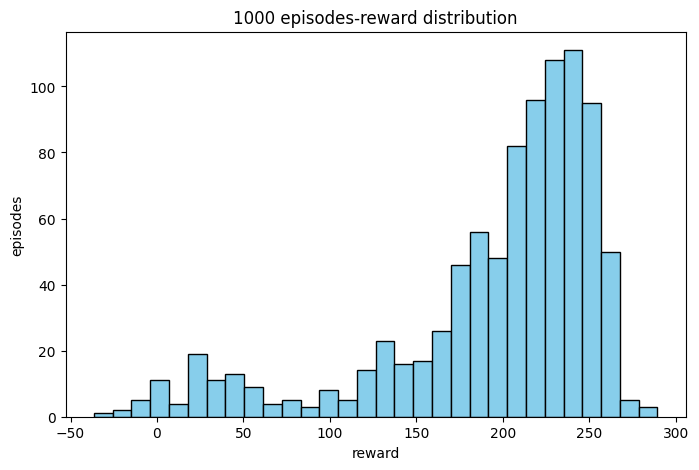

In [9]:
test_agent(agent,env="LunarLander-v3",num_envs=128,num_episodes=1000)

In [11]:
save_video(agent, env,'a2c_lunarlander.mp4')

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (600, 400) to (608, 400) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


In [26]:
from stable_baselines3 import PPO

env = gym.make("LunarLander-v3", render_mode="rbg_array")

model = PPO("MlpPolicy", env, verbose=1, ent_coef=0.2)
model.learn(total_timesteps=100_000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 97.1     |
|    ep_rew_mean     | -206     |
| time/              |          |
|    fps             | 783      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 93.1        |
|    ep_rew_mean          | -173        |
| time/                   |             |
|    fps                  | 432         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.005492553 |
|    clip_fraction        | 0.0562      |
|    clip_range           | 0.2         |
|    entropy_loss  

In [27]:
vec_env = model.get_env()
obs = vec_env.reset()
rewards = []
for episode in range(100):
    total_rewards = 0
    while True:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, info = vec_env.step(action)
        total_rewards += reward
        if done:
            rewards.append(total_rewards)
            break

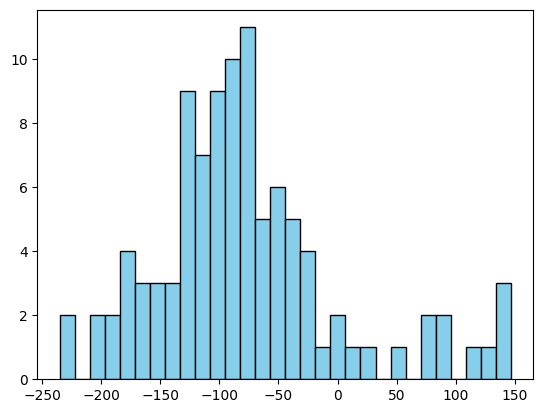

In [28]:
plt.hist(np.array(rewards).flatten(), bins=30, color='skyblue', edgecolor='black')
plt.show()